In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from sklearn.experimental import enable_iterative_imputer  # Required for IterativeImputer
from sklearn.impute import IterativeImputer
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import joblib
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/knnwaladatasets/y_test.csv
/kaggle/input/knnwaladatasets/X_Test.csv
/kaggle/input/knnwaladatasets/y_val.csv
/kaggle/input/knnwaladatasets/y_train.csv
/kaggle/input/knnwaladatasets/X_train.csv
/kaggle/input/knnwaladatasets/X_val.csv
/kaggle/input/cosmic-data/cosmic classifier data/thermoracleTest.csv
/kaggle/input/cosmic-data/cosmic classifier data/thermoracleTrain.csv
/kaggle/input/nn_model/tensorflow2/default/1/NN_Final.h5


In [7]:
X_train=pd.read_csv("/kaggle/input/knnwaladatasets/X_train.csv")
X_test=pd.read_csv("/kaggle/input/knnwaladatasets/X_Test.csv")
X_val=pd.read_csv("/kaggle/input/knnwaladatasets/X_val.csv")
Y_train=np.array(pd.read_csv("/kaggle/input/knnwaladatasets/y_train.csv")).flatten()
Y_test=np.array(pd.read_csv("/kaggle/input/knnwaladatasets/y_test.csv")).flatten()
Y_val=np.array(pd.read_csv("/kaggle/input/knnwaladatasets/y_val.csv")).flatten()

In [8]:
from sklearn.svm import SVC

## 1. SVM

In [9]:
svc_params_cb={
    'C': 1000, 
    'gamma': 0.003, 
    'kernel': 'rbf', 
    'degree': 5,
    'probability':True
}

In [15]:
svc_params={
    'C':10.0,                    
    'kernel':'rbf',               
    'gamma':0.02,                 
    'degree':3,                   
    'coef0':0.0,                  
    'shrinking':True,             
    'probability':True,           
    'tol':1e-2,                   
    'cache_size':500,             
    'class_weight':'balanced',    
    'max_iter':-1,                
    'decision_function_shape':'ovr', 
    'random_state':42
}

In [76]:
model_svc=SVC(**svc_params_cb)

In [78]:
model_svc.fit(X_train,np.array(Y_train))

SVC(C=1000, degree=5, gamma=0.003, probability=True)

In [79]:
print("Training Accuracy:",np.round(accuracy_score(Y_train,model_svc.predict(X_train))*100,2))
print("CV Accuracy:",np.round(accuracy_score(Y_val,model_svc.predict(X_val))*100,2))

Training Accuracy: 91.27
CV Accuracy: 90.16


In [80]:
joblib.dump(model_svc, "model_svc1.pkl")

['model_svc1.pkl']

## 2. LightGBM

In [25]:
import lightgbm as lgb

In [26]:
params_lgb = {
    "objective": "multiclass",
    "num_class": 10,  # Number of classes
    "metric": "multi_logloss",
    "boosting_type": "gbdt",  # Gradient Boosting Decision Trees
    "learning_rate": 0.2,
    "num_leaves": 50,
    "max_depth": 6,
    "min_data_in_leaf": 34,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose":-1,
    'random_state':42
}

In [27]:
train_data = lgb.Dataset(X_train, label=Y_train)
valid_data = lgb.Dataset(X_val, label=Y_val, reference=train_data)

In [28]:
model_lgb= lgb.train(
    params_lgb,
    train_data,
    num_boost_round=1000,
    valid_sets=[valid_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=10)  # Equivalent to verbose_eval=10
    ]
)

Training until validation scores don't improve for 50 rounds
[10]	valid_0's multi_logloss: 0.560673
[20]	valid_0's multi_logloss: 0.436107
[30]	valid_0's multi_logloss: 0.396435
[40]	valid_0's multi_logloss: 0.38223
[50]	valid_0's multi_logloss: 0.375789
[60]	valid_0's multi_logloss: 0.371889
[70]	valid_0's multi_logloss: 0.369573
[80]	valid_0's multi_logloss: 0.368351
[90]	valid_0's multi_logloss: 0.370567
[100]	valid_0's multi_logloss: 0.372308
[110]	valid_0's multi_logloss: 0.374701
[120]	valid_0's multi_logloss: 0.378014
Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.367651


In [29]:
print("Training Accuracy:",np.round(accuracy_score(Y_train,np.argmax(model_lgb.predict(X_train),axis=1))*100,2))
print("CV Accuracy:",np.round(accuracy_score(Y_val,np.argmax(model_lgb.predict(X_val),1))*100,2))

Training Accuracy: 98.21
CV Accuracy: 89.14


In [30]:
model_lgb.save_model("model_lgb.txt")

## 3. XGBoost

In [31]:
import xgboost as xgb

In [32]:
# Assuming X and y are your feature matrix and labels
# Convert data into XGBoost DMatrix format
train_data = xgb.DMatrix(X_train, label=Y_train)
valid_data = xgb.DMatrix(X_val, label=Y_val)

In [33]:
params_xgb = {
    "objective": "multi:softprob",  # Change to 'binary:logistic' for binary classification
    "num_class": 10,  # Number of classes (remove if binary classification)
    "eval_metric": "mlogloss",  # Use "logloss" for binary classification
    "learning_rate": 0.1,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
}

In [34]:
model_xgb = xgb.train(
    params_xgb,
    train_data,
    num_boost_round=600
)

In [35]:
print("Training Accuracy:",np.round(accuracy_score(Y_train,model_xgb.predict(train_data).argmax(axis=1))*100,2))
print("CV Accuracy:",np.round(accuracy_score(Y_val,model_xgb.predict(valid_data).argmax(axis=1))*100,2))

Training Accuracy: 100.0
CV Accuracy: 89.74


In [37]:
model_xgb.save_model("model_xgb.json")

## 4. Neural Network

import tensorflow as tf
from tensorflow.keras import layers, regularizers, models
from tensorflow.keras.callbacks import EarlyStopping

# Define the model architecture
model = models.Sequential([
    # Input layer
    layers.InputLayer(input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    
    # Hidden Layer 1
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    # Hidden Layer 2
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    # Hidden Layer 3
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    # Hidden Layer 4
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    
    # Hidden Layer 5
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    # Output layer: 10 neurons for 10 classes with softmax activation
    layers.Dense(10, activation='softmax')
])


# Compile the model with Adam optimizer and sparse categorical crossentropy loss
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

# Set up Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(X_val, Y_val, verbose=0)
print(f"Validation Accuracy: {val_acc:.2%}")


from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import numpy as np

# Define a simpler model with regularization
model = keras.Sequential([
    # Input layer
    layers.Dense(256, activation='relu', input_shape=(10,)),
    
    # Deeper block 1
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    
    # Deeper block 2
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    
    # Deeper block 3
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    
    # Output layer for 10 classes with softmax activation
    layers.Dense(10, activation='softmax')
])
# Compile the model with Adam optimizer and sparse categorical crossentropy loss


model.compile(optimizer=Adam(learning_rate=0.000005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, 
                    validation_data=(X_val, Y_val), 
                    epochs=1, 
                    batch_size=32,
                    verbose=1)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(X_val, Y_val)
print(f"Validation Accuracy: {val_acc:.2%}")


import matplotlib.pyplot as plt
plt.plot(np.arange(len(history.history['val_accuracy'])),history.history['val_accuracy'])

In [47]:
model=tf.keras.models.load_model("/kaggle/input/nn_model/tensorflow2/default/1/NN_Final.h5")

NameError: name 'tf' is not defined

In [48]:
print("Test Accuracy:",np.round(accuracy_score(Y_test,model.predict(X_test).argmax(axis=1))*100,2))

NameError: name 'model' is not defined

In [49]:
dataset=pd.read_csv("/kaggle/input/cosmic-data/cosmic classifier data/thermoracleTest.csv")

In [67]:
import joblib

In [68]:
imputer=joblib.load("/kaggle/input/imputer/scikitlearn/default/1/KNNImputer.pkl")

In [62]:
import re

In [63]:
def convert_category_columns(df, column_names):
    df_copy = df.copy()
    for column in column_names:
        df_copy[column] = df_copy[column].apply(lambda x: int(re.search(r'\d+', str(x)).group()) if pd.notna(x) and re.search(r'\d+', str(x)) else x)
    return df_copy

In [64]:
def clean_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """
    Takes a DataFrame, copies it, and transforms column names:
    - Converts uppercase letters to lowercase.
    - Replaces spaces with underscores.

    Args:
        df (pd.DataFrame): Input DataFrame.

    Returns:
        pd.DataFrame: Transformed DataFrame with cleaned column names.
    """
    df_copy = df.copy()
    df_copy.columns = (
        df_copy.columns
        .str.strip()            # Removes leading/trailing whitespaces
        .str.lower()            # Converts to lowercase
        .str.replace(" ", "_")  # Replaces spaces with underscores
    )
    return df_copy

In [69]:
def main_func(X_test):
    X_test=convert_category_columns(X_test,['Magnetic Field Strength','Radiation Levels'])
    X_test_copy=X_test.copy()
    X_test_copy=clean_column_names(X_test_copy)
    X_test_imputed=pd.DataFrame(imputer.transform(X_test),columns=X_test_copy.columns)
    return X_test_imputed

In [75]:
model_xgb.predict(xgb.DMatrix(main_func(dataset)))

array([[1.4054335e-06, 2.4827245e-06, 1.3586906e-05, ..., 9.9974984e-01,
        5.7493031e-07, 1.9467478e-04],
       [7.9428482e-06, 2.8447146e-05, 9.9671125e-01, ..., 2.0323241e-05,
        3.2169854e-05, 9.8827340e-06],
       [7.9276776e-07, 9.9991965e-01, 9.3497911e-06, ..., 1.9495877e-05,
        4.9511100e-06, 4.3936334e-06],
       ...,
       [1.8671707e-07, 8.5344062e-08, 1.7317058e-07, ..., 2.2366778e-06,
        2.0251110e-04, 5.7185936e-04],
       [7.9231709e-03, 5.1307932e-05, 5.5337183e-05, ..., 1.2764985e-04,
        2.9511475e-03, 3.3268778e-04],
       [7.3896066e-05, 1.2996631e-07, 3.5871027e-04, ..., 1.1310658e-07,
        3.5989394e-06, 4.4260514e-07]], dtype=float32)

,atmospheric_density,surface_temperature,gravity,water_content,mineral_abundance,orbital_period,proximity_to_star,magnetic_field_strength,radiation_levels,atmospheric_composition_index
0,-1.303074,2.932540,-0.168043,-1.220249,-1.942662,0.950473,1.540782,13.0,6.0,-0.729809
1,0.081124,-3.747390,-0.598897,1.563487,-0.199953,-1.844926,1.095349,11.0,10.0,-0.341850
2,-3.709952,-1.689588,0.259499,1.020046,-2.094565,0.344641,-0.094227,9.0,9.0,-0.532658
3,4.838804,0.442909,0.995312,-0.385272,-0.818065,-1.903998,2.727794,10.0,9.0,-0.205558
4,0.742217,2.802281,-1.144759,2.475840,-0.585959,0.880694,-1.942863,11.0,6.0,0.763087
...,...,...,...,...,...,...,...,...,...,...
9995,1.185221,-2.146064,-0.145847,1.056399,3.201846,3.729891,3.100994,11.0,5.0,-0.147794
9996,2.257602,-2.714023,-3.215728,-0.753216,0.460961,-0.793091,2.672126,16.0,8.0,-0.157080
9997,-1.059609,2.340662,1.392567,-1.627227,2.634176,0.638663,-0.165413,6.0,9.0,-3.148313
9998,-1.231524,-0.425901,2.520917,-0.993503,-0.577048,-1.083454,0.636375,11.0,11.0,-0.844913


In [ ]:
print("Test Accuracy:",np.round(accuracy_score(Y_test,model_xgb.predict(xgb.DMatrix(X_test,label=Y_test)).argmax(axis=1))*100,2))

In [ ]:
print("Test Accuracy:",np.round(accuracy_score(Y_test,np.argmax(model_lgb.predict(X_test),axis=1))*100,2))

In [ ]:
print("CV Accuracy:",np.round(accuracy_score(Y_test,model_svc.predict(X_test))*100,2))

In [41]:
Output_Predictions=pd.concat([
    pd.DataFrame(model_svc.predict(X_val).astype(int),columns=['SVC']),
    pd.DataFrame(np.argmax(model_lgb.predict(X_val),axis=1).astype(int),columns=['LightGBM']),
    pd.DataFrame(model_xgb.predict(xgb.DMatrix(X_val,label=Y_val)).argmax(axis=1).astype(int),columns=['XGBoost']),
    pd.DataFrame(model.predict(X_val).argmax(axis=1).astype(int),columns=['NN']),
    pd.DataFrame(Y_val.astype(int),columns=['True Value'])
],axis=1)

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [37]:
Output_Predictions_test=pd.concat([
    pd.DataFrame(model_svc.predict(X_test).astype(int),columns=['SVC']),
    pd.DataFrame(np.argmax(model_lgb.predict(X_test),axis=1).astype(int),columns=['LightGBM']),
    pd.DataFrame(model_xgb.predict(xgb.DMatrix(X_test,label=Y_test)).argmax(axis=1).astype(int),columns=['XGBoost']),
    pd.DataFrame(model.predict(X_test).argmax(axis=1).astype(int),columns=['NN']),
    pd.DataFrame(Y_test.astype(int),columns=['True Value'])
],axis=1)

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [42]:
Output_Predictions

,SVC,LightGBM,XGBoost,NN,True Value
0,6,6,6,6,6
1,2,2,2,2,2
2,8,8,8,8,8
3,8,8,5,5,8
4,4,4,4,4,9
...,...,...,...,...,...
11387,8,8,8,8,8
11388,1,1,1,1,1
11389,4,4,4,4,4
11390,8,8,8,8,8


In [43]:
Output_Predictions_test

,SVC,LightGBM,XGBoost,NN,True Value
0,0,0,2,2,1
1,8,8,8,8,8
2,6,6,6,6,6
3,3,3,3,3,3
4,2,2,2,2,2
...,...,...,...,...,...
11388,6,6,6,6,6
11389,9,9,9,9,9
11390,5,5,5,5,5
11391,0,0,0,0,0


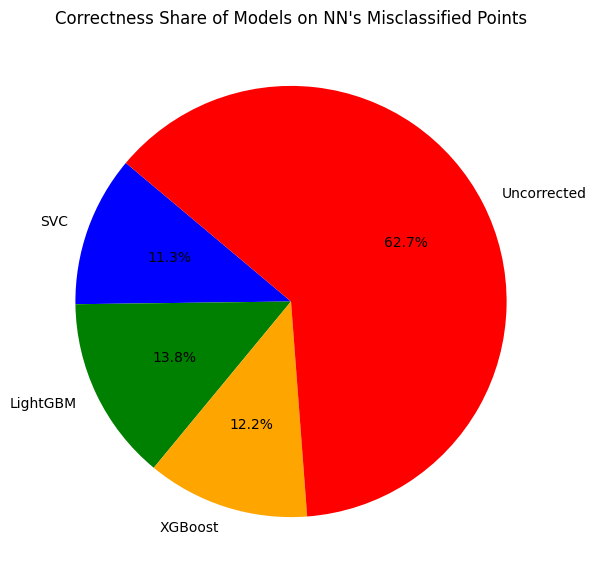

In [45]:
misclassified = Output_Predictions[Output_Predictions["NN"] != Output_Predictions["True Value"]]

correct_counts = {"SVC": 0, "LightGBM": 0, "XGBoost": 0, "Uncorrected": 0}

# Iterate through misclassified points and assign correctness to only one model
for _, row in misclassified.iterrows():
    correct_models = []
    if row["SVC"] == row["True Value"]:
        correct_models.append("SVC")
    if row["LightGBM"] == row["True Value"]:
        correct_models.append("LightGBM")
    if row["XGBoost"] == row["True Value"]:
        correct_models.append("XGBoost")

    if correct_models:
        chosen_model = np.random.choice(correct_models)  # Randomly assign to one correct model
        correct_counts[chosen_model] += 1
    else:
        correct_counts["Uncorrected"] += 1

# Data for pie chart
labels = list(correct_counts.keys())
sizes = list(correct_counts.values())
colors = ["blue", "green", "orange", "red"]

# Plot the pie chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title("Correctness Share of Models on NN's Misclassified Points")
plt.show()

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
n_classes=10

In [48]:
meta_train_data = pd.concat([
    # SVC probability outputs (shape: [n_samples, 10])
    pd.DataFrame(
        model_svc.predict_proba(X_val),
        columns=[f"SVC_{i}" for i in range(n_classes)]
    ),
    
    # LightGBM probability outputs (shape: [n_samples, 10])
    pd.DataFrame(
        model_lgb.predict(X_val),
        columns=[f"LightGBM_{i}" for i in range(n_classes)]
    ),
    
    # XGBoost probability outputs (shape: [n_samples, 10])
    pd.DataFrame(
        model_xgb.predict(xgb.DMatrix(X_val, label=Y_val)),
        columns=[f"XGBoost_{i}" for i in range(n_classes)]
    ),
    
    # Neural Network outputs (assuming it returns [n_samples, 10])
    pd.DataFrame(
        model.predict(X_val),
        columns=[f"NN_{i}" for i in range(n_classes)]
    ),
    
    # True labels (single column)
    pd.DataFrame(Y_val.astype(int), columns=["True Value"])
], axis=1)

356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [49]:
meta_test_data = pd.concat([
    # SVC probability outputs (shape: [n_samples, 10])
    pd.DataFrame(
        model_svc.predict_proba(X_test),
        columns=[f"SVC_{i}" for i in range(n_classes)]
    ),
    
    # LightGBM probability outputs (shape: [n_samples, 10])
    pd.DataFrame(
        model_lgb.predict(X_test),
        columns=[f"LightGBM_{i}" for i in range(n_classes)]
    ),
    
    # XGBoost probability outputs (shape: [n_samples, 10])
    pd.DataFrame(
        model_xgb.predict(xgb.DMatrix(X_test, label=Y_test)),
        columns=[f"XGBoost_{i}" for i in range(n_classes)]
    ),
    
    # Neural Network outputs (assuming it returns [n_samples, 10])
    pd.DataFrame(
        model.predict(X_test),
        columns=[f"NN_{i}" for i in range(n_classes)]
    ),
    
    # True labels (single column)
    pd.DataFrame(Y_test.astype(int), columns=["True Value"])
], axis=1)

357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [50]:
Output_Predictions.to_csv("Output_Predictions.csv",index=False)
Output_Predictions_test.to_csv("Output_Predictions_test.csv",index=False)
meta_train_data.to_csv("meta_train_data.csv",index=False)
meta_test_data.to_csv("meta_test_data.csv",index=False)

In [ ]:
X_meta=meta_train_data.drop('True Value',axis=1)
Y_meta=meta_train_data['True Value']
X_meta_test=meta_test_data.drop('True Value',axis=1)
Y_meta_test=meta_test_data['True Value']

In [ ]:
meta_params={
    'random_state':42,
}

In [ ]:
meta_learner=RandomForestClassifier(**meta_params)

In [ ]:
meta_learner.fit(X_meta,Y_meta)

## Stacking Alternate Approach

In [ ]:
df_correct = pd.DataFrame()

df_correct["SVC_correct"] = (Output_Predictions["SVC"] == Output_Predictions["True Value"]).astype(int)
df_correct["LightGBM_correct"] = (Output_Predictions["LightGBM"] == Output_Predictions["True Value"]).astype(int)
df_correct["XGBoost_correct"] = (Output_Predictions["XGBoost"] == Output_Predictions["True Value"]).astype(int)
df_correct["NN_correct"] = (Output_Predictions["NN"] == Output_Predictions["True Value"]).astype(int)

In [ ]:
df_correct_test = pd.DataFrame()

df_correct_test["SVC_correct"] = (Output_Predictions_test["SVC"] == Output_Predictions_test["True Value"]).astype(int)
df_correct_test["LightGBM_correct"] = (Output_Predictions_test["LightGBM"] == Output_Predictions_test["True Value"]).astype(int)
df_correct_test["XGBoost_correct"] = (Output_Predictions_test["XGBoost"] == Output_Predictions_test["True Value"]).astype(int)
df_correct_test["NN_correct"] = (Output_Predictions_test["NN"] == Output_Predictions_test["True Value"]).astype(int)

In [ ]:
X_cfinder=pd.read_csv("/kaggle/input/knnwaladatasets/X_val.csv")
Y_cfinder=df_correct.copy()

In [ ]:
X_cfinder_test=pd.read_csv("/kaggle/input/knnwaladatasets/X_Test.csv")
Y_cfinder_test=df_correct_test.copy()

In [ ]:
meta_params_cfinder={
    'random_state':42,
    'class_weight':'balanced_subsample'
}

In [ ]:
meta_learner_cfinder=RandomForestClassifier(**meta_params)

In [ ]:
meta_learner.fit(X_cfinder,Y_cfinder)

In [ ]:
accuracy_score(Y_cfinder_test,meta_learner.predict(X_cfinder_test))

In [ ]:
probas_list=meta_learner.predict_proba(X_cfinder_test)

In [ ]:
threshold=0.5

In [ ]:
converted_list = [(arr[:, 1] > threshold).astype(int) for arr in probas_list]

In [ ]:
converted_list

In [ ]:
y_prob = 

In [ ]:
best_thresh = 0.3  # example
y_pred = (y_prob >= best_thresh).astype(int)
print("Accuracy:", accuracy_score(Y_cfinder_test, y_pred))

In [ ]:
y_pred